In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_04 import *

# Initial setup

In [3]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [6]:
get_model??

Signature: get_model(data, lr=0.1, nh=50)
Docstring: <no docstring>
Source:   
def get_model(data, lr=0.1, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, data.c))
    return model, optim.Adam(model.parameters(), lr=lr)
File:      ~/repo/fastai-course-v3/nbs/dl2/selfmade/exp/nb_04.py
Type:      function


In [7]:
learn = create_learner(get_model, loss_func, data)

In [8]:
run = Runner([AvgStatsCallback([accuracy])])

In [9]:
run.fit(3, learn)

train: [0.5410560546875, tensor(0.8307)]
valid: [0.305468603515625, tensor(0.9097)]
train: [0.25001337890625, tensor(0.9261)]
valid: [0.22093310546875, tensor(0.9341)]
train: [0.20570859375, tensor(0.9388)]
valid: [0.18837420654296874, tensor(0.9428)]


In [10]:
learn = create_learner(partial(get_model, lr=0.2), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.5734218098958334, tensor(0.8237)]
valid: [0.3469111572265625, tensor(0.8908)]
train: [0.3056693359375, tensor(0.9105)]
valid: [0.26376806640625, tensor(0.9214)]
train: [0.26762156575520835, tensor(0.9208)]
valid: [0.252323828125, tensor(0.9250)]


In [11]:
def get_model_func(lr=0.1): return partial(get_model, lr=lr)

In [12]:
learn = create_learner(get_model_func(), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.5516190104166667, tensor(0.8325)]
valid: [0.3108656005859375, tensor(0.9098)]
train: [0.28402171223958333, tensor(0.9179)]
valid: [0.2505693115234375, tensor(0.9257)]
train: [0.241796484375, tensor(0.9300)]
valid: [0.22693115234375, tensor(0.9342)]


# Annealing

In [13]:
#export
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses = [], []
        
    def after_batch(self): 
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self): plt.plot(self.lrs)
    
    def plot_loss(self): plt.plot(self.losses)
        
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_func): self.pname, self.sched_func = pname, sched_func
        
    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs / self.epochs)
            
    def begin_batch(self):
        if self.in_train: self.set_param()

In [14]:
#export
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos * (end-start)
    
    return partial(_inner, start, end)

In [15]:
sched = sched_lin(1, 2)

In [16]:
sched(0.3) # jupyter does handle the partial functions really good in their signatures!

1.3

In [17]:
#export
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos * (end - start)

In [18]:
f = sched_lin(1, 2)

In [19]:
f(0.3)

1.3

In [20]:
#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end - start) / 2
@annealer
def sched_no(start, end, pos): return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

# This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

In [21]:
sched_exp(1, 2)(0.3), sched_exp(1, 2)(0.9)

(1.2311444133449163, 1.8660659830736148)

In [22]:
1e-2

0.01

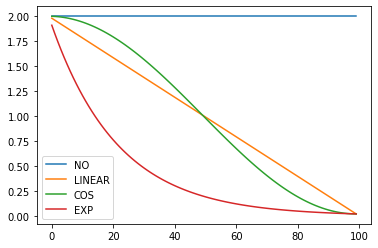

In [23]:
annealings = 'NO LINEAR COS EXP'.split()
schedulers = [sched_no, sched_lin, sched_cos, sched_exp]

x = torch.arange(0, 100)
y = torch.linspace(0.01, 1, 100)

for sched, name in zip(schedulers, annealings):
    func = sched(2, 2e-2)
    plt.plot(x, [func(o) for o in y], label=name)
plt.legend();

In [24]:
# torch.nonzero() # returns the indices of nonzero entries

In [25]:
#export
def combine_scheds(pcts, scheds): # combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
#     print(pcts) # pcts should be [0, 0.3, 1] now
    
    def _inner(pos): # with pos = 0.5
        idx = (pos >= pcts).nonzero().max()
#         print(idx) # should be 1 here
        if idx == 2: idx = 1 # why is that line needed?
        actual_pos = (pos - pcts[idx]) / (pcts[idx+1] - pcts[idx]) # should be (0.5 - 0.3) / (1 - 0.3) = 0.2 / 0.7
#         print(actual_pos)
        return scheds[idx](actual_pos)
    
    return _inner

In [26]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

In [27]:
sched(0.5)

0.5246979914392303

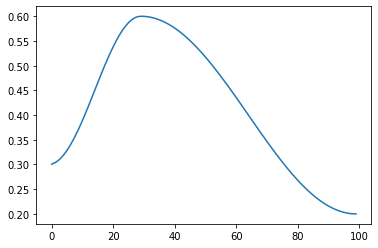

In [28]:
plt.plot(x, [sched(o) for o in y])

In [29]:
cbfs = [Recorder,
       partial(AvgStatsCallback, accuracy),
       partial(ParamScheduler, 'lr', sched)]

In [30]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner(cb_funcs=cbfs)

In [31]:
run.fit(3, learn)

train: [0.5783014322916666, tensor(0.8175)]
valid: [0.3305131591796875, tensor(0.8984)]
train: [0.3150408203125, tensor(0.9082)]
valid: [0.2585641845703125, tensor(0.9244)]
train: [0.24218665364583333, tensor(0.9296)]
valid: [0.2365904541015625, tensor(0.9314)]


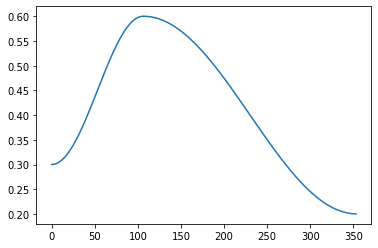

In [32]:
run.recorder.plot_lr()

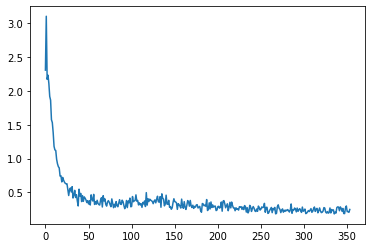

In [33]:
run.recorder.plot_loss()

# Export

In [34]:
!python notebook2script.py 05_anneal.ipynb

Converted 05_anneal.ipynb to exp/nb_05.py
